# Elliptic Curve Cryptography

In [40]:
from finite_field import FiniteFieldElement
from ec import EllipticCurve, ECPoint
from hashing import hash256
import random
import warnings
warnings.filterwarnings('ignore')

In the previous lessons we learned about finite fields, elliptic curves, point multiplication, the elliptic curve discrete logarithm problem (ECDLP), private keys and public keys. We will now combine all of these tools into the Elliptic Curve Digital Signature Algorithm, which is at the heart of Bitcoin transactions.

## Elliptic Curve Digital Signature Algorithm (ECDSA)

In Bitcoin, ECDSA is used for signing and verifying transactions. <br><br>
Remember that in Bitcoin, ownership of Bitcoin is equivalent to knowledge of the private key that belongs to the Bitcoin address that has those Bitcoin. This means that only the person who knows the private keys is able to spend the Bitcoin owned by that publicly available Bitcoin address. The way in which this is enforced by the network is that in order to send any Bitcoin from one address to another the person sending those Bitcoin needs to sign the transaction using the private key. This isgnature is constructed in such a way that anybody in the network can verify that the private key that was used to create the signature really belongs to the public key and therefore is authorised to send those Bitcoin. But how does this actually work? And how do you prove that you signed a transaction with your private key without ever revealing that private key?<br><br>
This is where ECDSA comes in. ECDSA can be broken down into three steps:
1. Key generation
2. Signing
3. Verification

We will first look at all these from a mathematical perspective and explain the formulas that underpin each step and then we will walk through a simplified example using Python code for a more intutive understanding.

## Key generation

As discussed in the previous lesson, a private key is simply a random integer, $d$ in the range $[1, ..., n-1]$ that is securely and randomly generated. The public key, $Q$, is the point on the elliptic curve that is the result of point multiplying the generator point, $G$, with the private key:
$$Q = dG$$ 
This multiplication is a one-way operation, making it computationally infeasible to derive the private key from the public key.<br><br>
The parameters that define the elliptic curve that Bitcoin uses (secp256k1) are publicly known, constant, and are the following:
- $a=0, b=7$, so that the curve equation is: $y^2 = x^3 + 7$
- Prime order of the finite field that the curve is over: $p = 2^{256} - 2^{32} - 977$
- Generator point, $G$, defined by the following x- and y-coordinates:
    - $G_x = 0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798$
    - $G_y = 0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8$
- Order of $G$: $n = 0xfffffffffffffffffffffffffffffffebaaedce6af48a03bbfd25e8cd0364141$

## Signing

In Bitcoin transactions, the message, $m$, that gets signed is just the hash of the serialisation of the transaction. This might sound confusing for anyone who hasn't seen what a serialised Bitcoin transaction looks like but it's essentially just a string of bytes that summarise the transaction and include information such as the version, the Bitcoin that is being spent (and where it came from previously) as well as which address(es) those Bitcoin are being sent to.<br><br>
The steps for creating the signature for a message are the following:

### 1. Hash the message, $m$:
- Compute $z = hash256(m)$.
- By hashing the message we create a fixed-size representation of the message. This also ensures that even the smallest change in the message creates a completely different hash, thereby adding to security.

### 2. Generate a random integer $k$
- Select a cryptographically secure random integer $k$ such that $1 <= k <= n-1$.
- This integer has to be kept secret by the signer, similar to how the private key has to be kept secret!
- $k$ is crucial for ensuring randomness and security of the signature. Why having this random integer as part of the signature is important will become clear shortly.

### 3. Compute the elliptic curve point $R$
- Compute the point $R = kG$, where $G$ is the generator point.
- This point corresponds to the random integer $k$ on the elliptic curve and can only be computed in this way by the signer.

### 4. Calculate the first part of the signature, $r$
- Compute $r = R_x \mod n$, where $R_x$ is the x-coordinate of the point $R$.
- If $r=0$, go back to step 2 and select a new random $k$.
- $r$ is the part of the signature that ties the signature to the random integer $k$.

### 5. Calculate the second part of the signature, $s$
- Compute $s=k^{-1}(z + r ⋅ d) \mod n$.
- If $s=0$, go back to step 2 and select a new random $k$.
- $s$ combined the private key with the message hash and the random integer $k$. It ensures that only the holde rof the private key could have produced the signature.

### 6. Output the signature
- The signature is the pair $(r, s)$.
- These two values, along with the private key, the publicly known parameters of the elliptic curve and the message are enpugh to verify the authenticity of the mesage and the signature withput revealing the private key.

## Signature Verification

In order to verify a signature on the Bitcoin blockchain we need the following parameters and variables:
- **Signature:**  $(r, s)$.
- **Public Key:** $Q$.
- **Curve parameters:** $G, n, p$.
- **Message Hash:** $z$.

Given all of these parameters and variables, the steps to verify a signature are the following:

### 1. Check Signature Validity
- Verify that $1 <= r <= n-1$ and $1 <= s <= n-1$.
- $r$ and $s$ must be valid integers within the order of the generator point.

### 2. Compute the inverse of $s$
- Compute $w = s^{-1} \mod n$.
- $w$ allows us to "unwind" the signature equation.

### 3. Calculate $u_1$ and $u_2$
- Compute $u_1 = z ⋅ w \mod n$ and $u_2 = r ⋅ w \mod n$.
- These values are used to combine the public key and the generator point in a way that allows the verifier to reconstruct the elliptic curve point corresponding to $r$.

### 4. Compute the Elliptic Curve Point $R'$
- Compute the point $R' = u_1G + u_2Q$, where $G$ is the generator point and $Q$ is the public key.
- This equation reconstructs $R$, which was previously compted using $k$ and $G$, without knowing $k$ through the values $u_1$ and $u_2$.

### 5. Calculate $v$
- Compute $v = R'_x \mod n$, where $R'_x$ is the x-coordinate or $R'$.
- $v$ should equal $r$ if the signature is valid.

### 6. Verify the Signature
- If $v = r$, the signature is valid.
- This proves that the signature was indeed created using the private key corresponding to the public key $Q$ and that the message has not been tampered with.

### Proof that the verification works

To see why the verification functions correctly we will show how the formulas come together. We start with the formula for $R'$ from step 4 of the verification process:
$$R' = u_1G + u_2Q$$
Substituting in the definition of the public key ($Q = dG$):
$$R' = u_1G + u_2 ⋅ d ⋅ G$$
Elliptic curve point multiplication distributes over addition so we can collect terms:
$$R' = (u_1G + u_2 ⋅ d) ⋅ G$$
Expanding the definition of $u_1$ and $u_2$:
$$R' = (z ⋅ w + r ⋅ d ⋅ w) ⋅ G$$
Collecting common term $w$:
$$R' = (z + r ⋅ d) ⋅ w ⋅ G$$
Because $w = s^{-1}$, we get:
$$R' = (z + r ⋅ d) ⋅ (z + r ⋅ d)^{-1} ⋅ (k^{-1})^{-1} ⋅ G$$
The product of an element and its inverse is the identity and the inverse of an inverse is just the orignal element, so we get:
$$R' = k ⋅ G$$

### Why $k$ is such as crucial part of the signing process

The reasons we need randomness in the integer $k$ are the following:<br><br>
**1. Unique Signature for each message**: because $k$ is selected anew and randomly for each signature, the signature will be unique even if the same message is signed multiple times using the same private key.<br><br>
**2. Protection against key exposure**: if we resued the same $k$ and an attacker noticed this, they could set up a system of linear equations that allows them to solve for $d$, i.e. the private key.<br><br>
**3. Cryptographic security**: $k$ effectively adds a layer of randomness and security to the signature process.

The main purpose of the random integer $k$ in this entire process is to mix the private key with a random component, both of which are kept secret, in a way that prevetns the private key from being isolated and exposed, even if an attacker has multiple signatures from the same private key. Combining a random component that noone knows about ($k$) and that always changes with a constant component that noone knows about ($d$) makes it impossible for anyone to figure out the constant unknown component because it gets "mixed up" or "scrambled" with the random secret component. Without $k$, the entire signing process wouldn't provide any security because then it would only rely on known variables such as the public key, message hash, elliptic curve parameters and one "secret" component, $d$, but one can easily backsolve for that component without the randomness introduced by $k$.<br><br>
The inclusion of k ensures that the signature is both verifiable and secure, preventing attackers from backsolving for the private key while still allowing anyone with the public key to verify the authenticity of the signature.

### How $s^{-1}$ undoes the randomness introduced by $k$ and why it's important

The key idea is that the authenticity of the signature should only depend on verifying that the signer knows the private key $d$. However, since the signature process involves randomness through $k$, verification needs to "cancel out" $k$ to focus only on the influence of $d$. The use of $k^{-1}$ in the signature generation and $s^{-1}$ in the verification allows this to happen, ensuring that the signature is valid while keeping both $k$ and $d$ secret. In essence, the role of $k^{-1}$ (and subsequently $s^{-1}$) is to isolate the effect of $d$ during verification so that the verifier can be confident that the correct private key was used, without needing to know $k$ or $d$ directly.

## Example Signature Creation and Verification

### Example private key and public key

After covering the algorithms and mathematics behind ECDSA, let's look at an example of this on a really small elliptic curve over a finite field. We will use the elliptic curve $y^2 = x ^3 - x + 1$ over the finite field $F_{29}$ and the generator point $G = (5, 18)$:

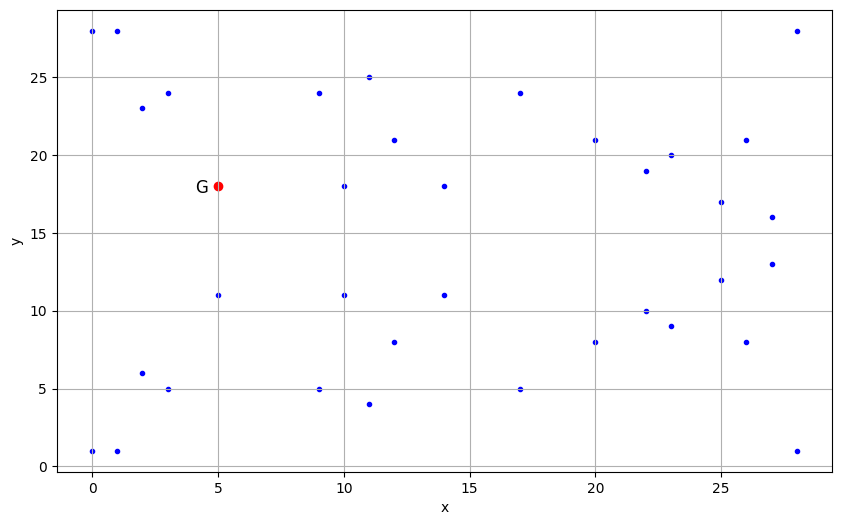

In [43]:
p = 29
a = FiniteFieldElement(-1 % p, p)
b = FiniteFieldElement(1, p)
curve = EllipticCurve(a, b)
G_x = FiniteFieldElement(5, p)
G_y = FiniteFieldElement(18, p)
G = ECPoint(G_x, G_y, curve)
n = 37
curve.plot_curve_over_field(point=G)

The first step is to create a private and a public key. We will use a byte string of our choosing, hash it using double SHA256 and then convert it into an integer modulo $n$ as our private key and then point multiply the generator point by it to get the public key, $Q$. The private key is generated this way purely for demonstration purposes and something like this should never be done in practice!

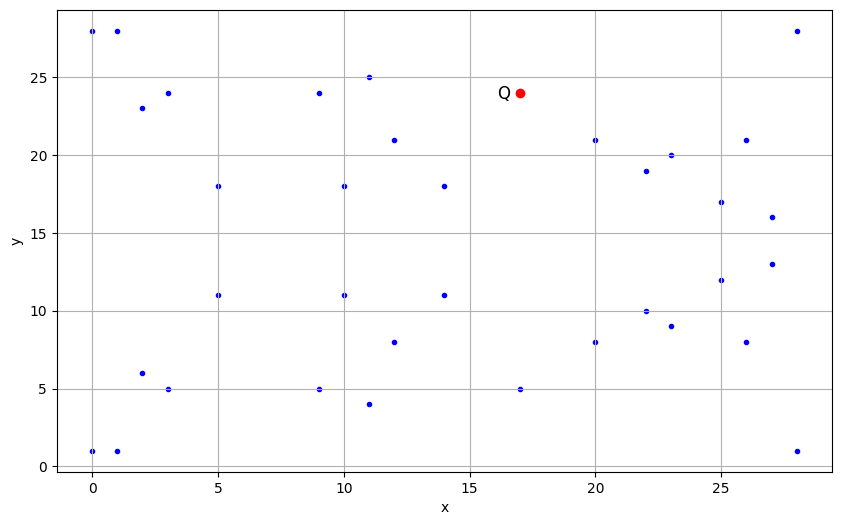

In [44]:
secret = int.from_bytes(hash256(b'Satoshi Nakamoto'), 'big')
d = secret % n
Q = d * G
curve.plot_curve_over_field(point=Q, p_label='Q')
# print(f'The public key corresponding to the private key {d} is: {(Q.x.num, Q.y.num )}')

As we learned previosuly, the public key is just a point on the elliptic curve. In case of our private key, $28$, the resulting public key has the coordinates $(17, 24)$. Now let's walk through the signing process step by step:

### Example Signature

#### 1. Hash the message, $m$
For the message we will alos use an arbitrary byte string, converted into an integer. We will once again compute $z$ modulo $n$ to make sure it falls within the group range.

In [46]:
m = b'Send 0.1 Bitcoin to Satoshi Nakamoto'
z = int.from_bytes(hash256(m), 'big') % n
print(f'Message Hash (z): {z}')

Message Hash (z): 16


#### 2. Generate a random integer $k$

In [47]:
k = random.randint(1, n-1)
print(f"Random k: {k}")

Random k: 31


#### 3. Compute the elliptic curve point $R$

In [48]:
R = k * G
print(f"R: {(R.x.num, R.y.num)}")

R: (2, 6)


#### 4. Calculate the first part of the signature, $r$

In [49]:
r = R.x.num
print(f'r: {r}')

r: 2


#### 5. Calculate the second part of the signature, $s$

In [50]:
k_inv = FiniteFieldElement(k, n) ** -1
s = (k_inv.num * (z + r * d)) % n
print(f's = {s}')

s = 25


#### 6. Output the signature

In [51]:
sig = (r, s)
print(f'Signature: {sig}')

Signature: (2, 25)


### Example Signature Verification

Now let's go through the verification process step by step:

#### 1. Check Signature Validity

In [52]:
r = sig[0]
s = sig[1]
print(f'r is valid: {r > 0 & r < n}')
print(f's is valid: {s > 0 & s < n}')

r is valid: True
s is valid: True


#### 2. Compute the inverse of $s$

In [53]:
w = (FiniteFieldElement(s, n) ** -1).num % n
print(f'w: {w}')

w: 3


#### 3. Calculate $u_1$ and $u_2$

In [54]:
u_1 = (z * w) % n
u_2 = (r * w) % n
print(f'u1: {u_1}, u2: {u_2}')

u1: 11, u2: 6


#### 4. Compute the Elliptic Curve Point $R'$

In [55]:
R_ = u_1 * G + u_2 * Q
print(f'R\': {(R_.x.num, R_.y.num)}')

R': (2, 6)


### 5. Calculate $v$ and 6. Verify the Signature

In [56]:
v = R.x.num
print(f'v is equal to r: {v == r}')

v is equal to r: True


We have successfully verified the signature and proven that the signer had to have had knowledge of the private key, $d$, to sign the transaction.<br><br>
The mechanism is exactly the same for ECDSA on Bitcoin's elliptic curve, the value of the integers that the variables can take is just vastly larger. Using the same the private key and message over Bitcoin's elliptic curve looks as follows:

#### Signature Creation on Bitcoin's elliptic curve

In [57]:
# Define parameters of secp256k1
n = 0xfffffffffffffffffffffffffffffffebaaedce6af48a03bbfd25e8cd0364141
p = 2 ** 256 - 2 ** 32 - 977

# Define the Bitcoin curve
a = FiniteFieldElement(0, p)
b = FiniteFieldElement(7, p)
btc_curve = EllipticCurve(a, b)

# Create the generator 
G_x = FiniteFieldElement(0x79be667ef9dcbbac55a06295ce870b07029bfcdb2dce28d959f2815b16f81798, p)
G_y = FiniteFieldElement(0x483ada7726a3c4655da4fbfc0e1108a8fd17b448a68554199c47d08ffb10d4b8, p)
G = ECPoint(G_x, G_y, btc_curve)

# Create private and public key
secret = int.from_bytes(hash256(b'Satoshi Nakamoto'), 'big')
d = secret % n
Q = d * G
print(f'Private key (d): {d}\n')
print(f'The public key (Q):\n({Q.x.num},\n {Q.y.num})\n')

# 1. Hash the message
m = b'Send 0.1 Bitcoin to Satoshi Nakamoto'
z = int.from_bytes(hash256(m), 'big') % n
print(f'Message Hash (z): {z}\n')

# 2. Generate a random integer k
k = random.randint(1, n-1)
print(f"Random k: {k}\n")

# 3. Compute the elliptic curve point R
R = k * G
print(f'R: ({R.x.num},\n    {R.y.num})\n')

# 4. Calculate the first part of the signature, r
r = R.x.num
print(f'r: {r}')

# 5. Calculate the second part of the signature, s
k_inv = FiniteFieldElement(k, n) ** -1
s = (k_inv.num * (z + r * d)) % n
print(f's = {s}\n')

# 6. Output the signature
sig = (r, s)
print(f'Signature: ({sig[0]},\n            {sig[1]})\n')

Private key (d): 15347435467633910075102098082213037117011454378824675510569767404987889485607

The public key (Q):
(21811169802197051269054468546803067869118132299621442904016337768954148287522,
 56608919366188758187152936660368979637141300997575071110010417636273132022178)

Message Hash (z): 37164022153960300488979650053899892666954836167732657308788256862398775396684

Random k: 87734639198116067754920911641869270516746429410670976305552382298962961381180

R: (36503622066953836631395372239059059982470247564576056465481912919211418519515,
    39871458617220963550680146363765682560887125469693348559786424712893967457158)

r: 36503622066953836631395372239059059982470247564576056465481912919211418519515
s = 65329030118596856111996012569994418290434563254565576661085935978409157674174

Signature: (36503622066953836631395372239059059982470247564576056465481912919211418519515,
            65329030118596856111996012569994418290434563254565576661085935978409157674174)



We can see that the privae key is a way larger integer than in the previous example. The same applies to the message hash. This, in combination with really large integer values as the x- and y-coordinates of the generator point, result in way bigger integer values for everything in the entire process compared to the small example we saw before. This is exactly where the security of Bitcoin comes from. The prior example could've easily been solved for using brute force. This becomes astronomically more difficult for the example using Bitcon's elliptic curve.

#### Signature Verification on Bitcoin's elliptic curve

In [58]:
# 1. Check Signature Validity
r = sig[0]
s = sig[1]
print(f'r is valid: {r > 0 & r < n}')
print(f's is valid: {s > 0 & s < n}\n')

# 2. Compute the inverse of s, w
w = (FiniteFieldElement(s, n) ** -1).num % n
print(f'w: {w}\n')

# 3. Calculate u_1 and u_2
u_1 = (z * w) % n
u_2 = (r * w) % n
print(f'u1: {u_1} \nu2: {u_2}\n')

# 4. Compute the Elliptic Curve Point R'
R_ = u_1 * G + u_2 * Q
print(f'R\': ({R_.x.num},\n     {R_.y.num})\n')

# 5. Calculate v
v = R.x.num

# 6. Verify the Signature
print(f'v is equal to r: {v == r}')
if v == r:
    print('Valid signature')
else:
    print('Invalid signature')

r is valid: True
s is valid: True

w: 84857020912524230706827266932489468544696398419884134617484131179196357981421

u1: 84240493626063981383252475027331449265623030156762314155426705044261420448798 
u2: 113280586480788379153162783605430482699959936670157439821569595902133512207213

R': (36503622066953836631395372239059059982470247564576056465481912919211418519515,
     39871458617220963550680146363765682560887125469693348559786424712893967457158)

v is equal to r: True
Valid signature


Walking through the signature creation and verification process step by step and looking at the results hopefully makes the ECDSA algorithm more tangible and intuitive. The essence of ECDSA is in the way it securely mixes a one-time random number with the private key to create a signature that proves the signer knows the private key. The process is designed so that the private key remains secret, even as others can verify that the signature is valid using the public key.<br><br>

This combination of randomness, cryptographic math, and the hidden secret (the private key) is what makes ECDSA both secure and verifiable.

## Summary

In this lesson we learned:
- How a Bitcoin signature is created.
- How that signature is verified without revealing the private key used to create the signature.
- What the role of the random number, $k$, is and why it's so important.
- What the process looks like on a step-by-step basis for a small example ellitpic curve as well as Bitcoin's elliptic curve.
Brilliant. We now understand elliptitc curve cryptography and how messages (i.e. transactions) get signed and verified on the Bitcoin blockchain!

The next step from here is to learn about Bitcoin transactions, what information they contain, how they are created and serialized and to then combine this knowledge with the knowledge of the ECDSA process from this lesson. Enjoy!